In [6]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import matplotlib.patches as patches
from scipy import stats
from Bio import SeqIO
import matplotlib.pyplot as plt
from IPython.display import Image, display
from tqdm.notebook import tqdm
import sys
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from config import *
from util.evaluation import ModelResultsManager, calculate_correlations, balancing_only_for_one_task, obtain_all_model_auc, remove_outliers, map_thermodynamic_columns, obtain_df_auc, replace_outliers_with_nan_and_make_positive, obtain_sr_nosr, map_dataset_to_hp
from models.nt_classifier import build as build_model 
from util.plot_utils import obtain_plot, plot_logs, collect_results_based_on_confidence_level_how_many1, acc_for_each_class
from util.plot_utils import collect_results_based_on_confidence_level_based_on_percentile as collect_results_based_on_confidence_level
from train_binary_cl import (
    get_args_parser,
)

from dataset.data import (
    FindSplits,
    RNADatasetInference
)

In [7]:
external_dataset_files_dir = os.path.join(ROOT_DIR, "dataset", "external_dataset")
windows_dir = os.path.join(external_dataset_files_dir, "windows")

In [8]:
def collect_result(rna1, rna2, model):
    rna1, rna2 = rna1.to(device), rna2.to(device)
    outputs = model(rna1, rna2)
    probability = float(outputs.softmax(-1)[:, 1])
    return probability

def make_plot(heatmap_data, interacting_regions, x_range, y_range, rna1_name='RNA1', rna2_name='RNA2', model_name = 'NT', savepath = '', show_plot = False):
    # Create a DataFrame for the heatmap
    heatmap_df = pd.DataFrame(heatmap_data, columns=x_range, index=y_range)

    # Create a custom color map (cmap) that goes from 0 (blue) to 1 (red)
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Create the heatmap using Seaborn
    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_df, cmap=cmap, cbar=True, vmin=0, vmax=1)

    for x1_real, width, y1_real, height in interacting_regions:
        rect = patches.Rectangle((x1_real, y1_real), width, height, linewidth=1.5, edgecolor='black', facecolor='none')
        plt.gca().add_patch(rect)

    # Set axis labels and title
    plt.xlabel(rna1_name)
    plt.ylabel(rna2_name)
    plt.title(f'{model_name} Intensity of prob for Each Window')
    
    if savepath:
        plt.savefig(savepath)

    if show_plot:
        # Show the plot
        plt.show()

In [9]:
sys.argv = ['']
parser = argparse.ArgumentParser('Training', parents=[get_args_parser()])
args = parser.parse_args()

model_name  = 'arch2_PARISfinetuned_PARIStest0023_PARISfinetunedFPweight_PARIStest0086'

# OR LIKE THIS?
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', f'/data01/giorgio/RNARNA-NT/checkpoints/{model_name}')
with open(os.path.join(checkpoint_dir, 'args.pkl'), 'rb') as fp:
    args = pickle.load(fp)

In [70]:
DEVICE = 'cuda' #cpu, cuda

args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)
args.resume = os.path.join(checkpoint_dir, 'best_model.pth') # best_model

device = torch.device(DEVICE)
model = build_model(args)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

model.to(device)
model.eval()

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


BinaryClassifierNT2(
  (nt_projection_module): NTProjectionModule(
    (conv1d): Conv1d(2560, 0, kernel_size=(1,), stride=(1,))
    (bn): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (top_classifier): MLP(
    (input_layer): Sequential(
      (0): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=5120, out_features=512, bias=True)
    )
    (hidden_layers): ModuleList()
    (output_layer): Linear(in_features=512, out_features=800, bias=True)
    (activation_functions): ModuleList(
      (0): Tanh()
    )
    (dropout_layers): ModuleList(
      (0): Dropout(p=0.01, inplace=False)
    )
  )
  (small_cnn): SmallCNN(
    (conv1): Conv2d(800, 300, kernel_size=(2, 2), stride=(1, 1))
    (conv2): Conv2d(300, 300, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
    (maxpool2d): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (tanh): Tanh()
    (global_avg_pool): AdaptiveAvgPool2d(

### Paoletto

In [11]:
paoletto_dir = '/data01/giorgio/RNARNA-NT/dataset/external_dataset/paoletto/'
embedding_dir =  os.path.join(paoletto_dir,'embeddings','32')

output_dir = os.path.join(paoletto_dir, 'output')
if os.path.isdir(output_dir) == False:
    os.mkdir(output_dir)

In [55]:
seq = pd.read_csv(os.path.join(paoletto_dir, 'seq.csv'))
seq['len'] = seq.cdna.apply(lambda x: len(x))

In [60]:
seq

,id_query,cdna,len
0,1a,AAAAGTTTGCCGGCTTCCGCAGTGATGGATCACCGTTTTAGTGGCA...,1068
1,1b,GCATTAATAGTAATACAGATAACGGGTTTGAAAGAATTCTCTACTG...,6927
2,1c,TTAAACCCCCTTCAAGGAAAAGCAAAACAAAACTGCTGCCTCATTT...,9208
3,2a,CTGTTAACTCCTCACCGTCAGCCTCCGAGACCATGATCATTCTCCC...,631
4,2b,GATTTTTGACGATTCCTTCCCTGAGAAGAGGGCGAGGAGAAGAAGA...,2099


In [56]:
new_rows = []

new_rows.append({
    'id_query': '1b_1',
    'cdna': seq.iloc[1].cdna[:5970],
    'len': len(seq.iloc[1].cdna[:5970])
})

new_rows.append({
    'id_query': '1b_2',
    'cdna': seq.iloc[1].cdna[1000:1000+5970],
    'len': len(seq.iloc[1].cdna[1000:1000+5970])
})

new_rows.append({
    'id_query':'1c_1',
    'cdna': seq.iloc[2].cdna[:5970],
    'len': len(seq.iloc[2].cdna[:5970])
})

new_rows.append({
    'id_query':'1c_2',
    'cdna': seq.iloc[2].cdna[2000:2000+5970],
    'len': len(seq.iloc[2].cdna[2000:2000+5970])
})

new_rows.append({
    'id_query':'1c_3',
    'cdna': seq.iloc[2].cdna[4000:4000+5970],
    'len': len(seq.iloc[2].cdna[4000:4000+5970])
})

new_rows = pd.DataFrame(new_rows)
embs=pd.concat([seq, new_rows], axis = 0)
embs = embs[embs.len<=5970]
embs.to_csv(os.path.join(paoletto_dir, 'embedding_query.csv'))

### NOW DOWNLOAD EMBEDDINGS
nohup python download_embeddings.py --batch_size=1 --path_to_embedding_query_dir=/data01/giorgio/RNARNA-NT/dataset/external_dataset/paoletto/ --embedding_dir=/data01/giorgio/RNARNA-NT/dataset/external_dataset/paoletto/embeddings &> download_embeddings.out &


In [64]:
combinations = [
    ['1a','1b_1'],
    ['1a','1b_2'],
    ['1a','1c_1'],
    ['1a','1c_2'],
    ['1a','1c_3'],
    ['2a','2b'],
]

In [72]:
embedding_dir

'/data01/giorgio/RNARNA-NT/dataset/external_dataset/paoletto/embeddings/32'

In [76]:
STEP_SIZE = 200

x1_start, y1_start = 0, 0

for emb1_name,emb2_name in combinations:
    id_sample = emb1_name + '_' + emb2_name
    cdna1 = embs[embs.id_query == emb1_name].cdna.iloc[0]
    cdna2 = embs[embs.id_query == emb2_name].cdna.iloc[0]
    len1 = len(cdna1)
    len2 = len(cdna2)
    
    emb1_path = os.path.join(embedding_dir, emb1_name + '.npy')
    emb2_path = os.path.join(embedding_dir, emb2_name + '.npy')

    assert os.path.isfile(emb1_path)
    assert os.path.isfile(emb2_path)

    emb1 = np.load(emb1_path)
    emb2 = np.load(emb2_path)

    # no overlap setup
    step_size = STEP_SIZE
    fs = FindSplits(max_size = step_size + 1)
    gene1_coords = pd.Series(len1).apply(lambda x: fs.get_split_coords(length = x, step_size=step_size)).iloc[0]
    gene2_coords = pd.Series(len2).apply(lambda x: fs.get_split_coords(length = x, step_size=step_size)).iloc[0]

    coord_dict = {}

    idx = 0

    for (x1, x2) in gene1_coords:
        
        for (y1, y2) in gene2_coords:

            cdna1_slice = cdna1[x1_start + x1: x1_start + x2]
            cdna2_slice = cdna2[y1_start + y1: y1_start + y2]

            assert len(cdna1_slice) == x2-x1
            assert len(cdna2_slice) == y2-y1

            x1_emb, x2_emb, y1_emb, y2_emb = x1//6, x2//6, y1//6, y2//6
            embedding1 = emb1[x1_emb:x2_emb, :]
            embedding2 = emb2[y1_emb:y2_emb, :]
            rna1, rna2 =  torch.as_tensor(embedding1).unsqueeze(0), torch.as_tensor(embedding2).unsqueeze(0)
            rna1, rna2 = torch.transpose(rna1, 1, 2), torch.transpose(rna2, 1, 2)
            probability = collect_result(rna1, rna2, model)
            coord_dict[idx] = {'x1': x1, 'x2':x2, 'y1':y1, 'y2':y2, 'prob':probability,
                               'cdna1_slice':cdna1_slice, 'cdna2_slice':cdna2_slice}
            idx += 1


    result = pd.DataFrame.from_dict(coord_dict, 'index')

    assert result.shape[0] > 0

    dir_row = os.path.join(output_dir, str(id_sample))
    if os.path.isdir(dir_row) == False:
        os.mkdir(dir_row)

    result.to_csv(os.path.join(dir_row, 'nt_result.csv'), index = False)

# Let's read and save the results

In [179]:
def merge_dataframes_and_calculate_mean(*dfs):
    # Start with the first dataframe
    final_df = dfs[0].copy()
    
    # Iterate through the rest of the dataframes
    for i, df in enumerate(dfs[1:], start=1):
        suffix = f'_new{i}'  # Suffix to ensure unique prob columns if we have more than two dataframes
        # Merge on the common x1, x2, y1, y2
        final_df = final_df.merge(df, on=['x1', 'x2', 'y1', 'y2'], how='outer', suffixes=('', suffix))
    
    # Get all columns that start with 'prob' (including prob, prob_new1, prob_new2, etc.)
    prob_columns = [col for col in final_df.columns if col.startswith('prob')]
    
    # Calculate the mean across all prob columns, skipping NaN values
    final_df['prob'] = final_df[prob_columns].mean(axis=1, skipna=True)
    
    # Drop the individual prob columns and keep only the final mean prob
    final_df = final_df.drop(columns=[col for col in prob_columns if col != 'prob'])
    
    return final_df

def heatmap_from_result(result, x_range, y_range):

    # Create an empty 2D array to store the prob values in the grid
    heatmap_data = [[0 for _ in x_range] for _ in y_range]

    # Fill the heatmap_data with 'prob' values
    for _, row in result.iterrows():
        x1, x2, y1, y2, prob = row
        x1, x2, y1, y2 = int(x1), int(x2), int(y1), int(y2)
        for x in range(x1, x2):
            for y in range(y1, y2):
                heatmap_data[y][x] = prob
    return heatmap_data

In [174]:
output_dir = os.path.join(paoletto_dir, 'output')

In [175]:
a1b1_1 = pd.read_csv(os.path.join(output_dir, '1a_1b_1', 'nt_result.csv'))[['x1', 'x2', 'y1', 'y2', 'prob']]
a1b1_2 = pd.read_csv(os.path.join(output_dir, '1a_1b_2', 'nt_result.csv'))[['x1', 'x2', 'y1', 'y2', 'prob']]
a1b1_2.y1 = a1b1_2.y1 + 1000
a1b1_2.y2 = a1b1_2.y2 + 1000

result = merge_dataframes_and_calculate_mean(a1b1_1, a1b1_2)

In [176]:
x_range = range(0, int(result.max().x2))
y_range = range(0, int(result.max().y2))
heatmap_data = heatmap_from_result(result, x_range, y_range)

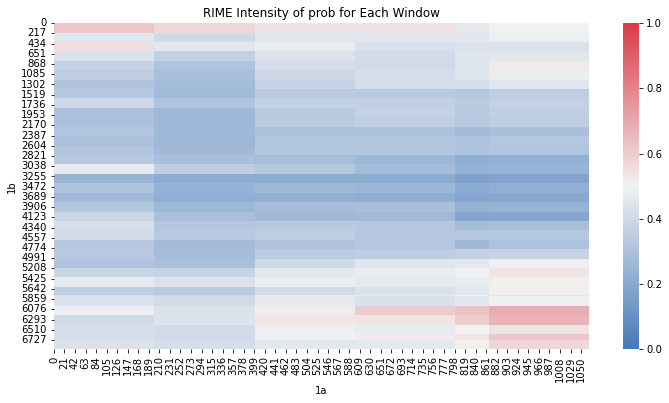

In [160]:
id_sample = '1a1b'
savepath = os.path.join(plot_dir, f'{id_sample}_RIME.png')
if os.path.exists(savepath) == False:
    make_plot(heatmap_data, [], x_range, y_range, rna1_name='1a', rna2_name='1b', model_name = 'RIME', savepath = savepath, show_plot = True)

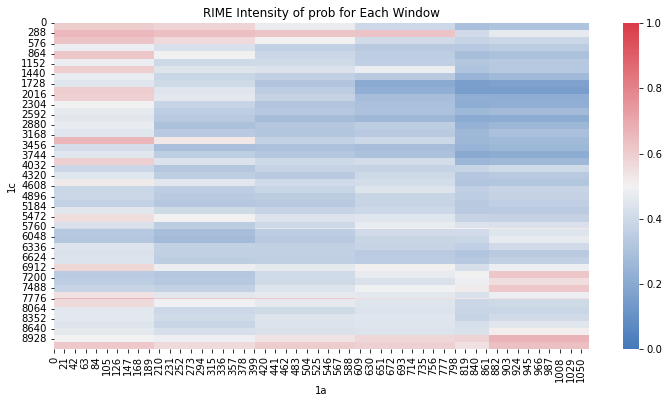

In [180]:
a1c1_1 = pd.read_csv(os.path.join(output_dir, '1a_1c_1', 'nt_result.csv'))[['x1', 'x2', 'y1', 'y2', 'prob']]
a1c1_2 = pd.read_csv(os.path.join(output_dir, '1a_1c_2', 'nt_result.csv'))[['x1', 'x2', 'y1', 'y2', 'prob']]
a1c1_3 = pd.read_csv(os.path.join(output_dir, '1a_1c_3', 'nt_result.csv'))[['x1', 'x2', 'y1', 'y2', 'prob']]
a1c1_2.y1 = a1c1_2.y1 + 2000
a1c1_2.y2 = a1c1_2.y2 + 2000
a1c1_3.y1 = a1c1_3.y1 + 4000
a1c1_3.y2 = a1c1_3.y2 + 4000

result = merge_dataframes_and_calculate_mean(a1c1_1, a1c1_2, a1c1_3)

x_range = range(0, int(result.max().x2))
y_range = range(0, int(result.max().y2))
heatmap_data = heatmap_from_result(result, x_range, y_range)

id_sample = '1a1c'
savepath = os.path.join(plot_dir, f'{id_sample}_RIME.png')
if os.path.exists(savepath) == False:
    make_plot(heatmap_data, [], x_range, y_range, rna1_name='1a', rna2_name='1c', model_name = 'RIME', savepath = savepath, show_plot = True)

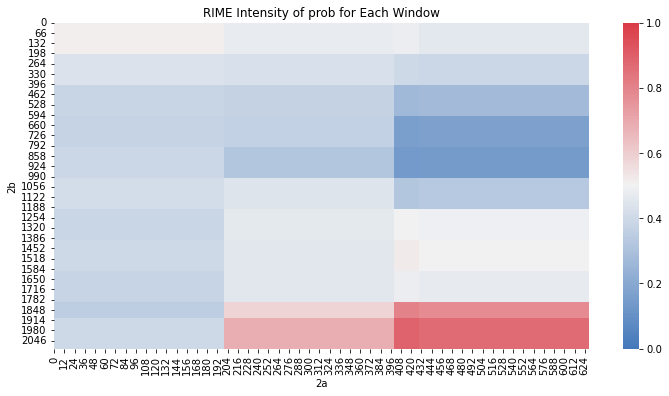

In [181]:
result = pd.read_csv(os.path.join(output_dir, '2a_2b', 'nt_result.csv'))[['x1', 'x2', 'y1', 'y2', 'prob']]

x_range = range(0, int(result.max().x2))
y_range = range(0, int(result.max().y2))
heatmap_data = heatmap_from_result(result, x_range, y_range)

id_sample = '2a_2b'
savepath = os.path.join(plot_dir, f'{id_sample}_RIME.png')
if os.path.exists(savepath) == False:
    make_plot(heatmap_data, [], x_range, y_range, rna1_name='2a', rna2_name='2b', model_name = 'RIME', savepath = savepath, show_plot = True)